In [81]:
import os

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [83]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(2)/file_gabungan2.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,Lenovo Legion Y540 - i7 9750H 16GB 512ssd 1TB ...,16999000,2013-01-01,13
1,ASUS ROG G531GU-I566G2T i5 9300H|8GB|512GB SSD...,16899000,2013-01-02,11
2,ASUS ROG GU502GU-I7664B Zephyrus M i7 9750H|16...,28299000,2013-01-03,14
3,ASUS ROG Strix G531GV-I7R6S1T [Scar 3],30999000,2013-01-04,13
4,ASUS ROG G531GT-I765G1T STRIX III i7-9750H 8GB...,16999000,2013-01-05,10
5,ASUS ROG HERO G531GU-I766H2T i7-9750H-16GB-256...,24590000,2013-01-06,12
6,ASUS ROG STRIX III G531GT-I765G4B i7-9750H|8GB...,17499000,2013-01-07,10
7,Asus ROG Zephyrus M GX502GW i7 9750 16GB 1TB S...,29199000,2013-01-08,9
8,ASUS ROG STRIX G G731GT,18499000,2013-01-09,12
9,ASUS ROG STRIX G512LU-I766B6T i7-10750H 8GB 51...,20553000,2013-01-10,9


In [84]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103000 entries, 0 to 102999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    103000 non-null  object
 1   price   103000 non-null  int64 
 2   date    103000 non-null  object
 3   sales   103000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [85]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [86]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103000 entries, 0 to 102999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    103000 non-null  object
 1   sales   103000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [87]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [88]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103000 entries, 0 to 102999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    103000 non-null  datetime64[ns]
 1   sales   103000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 MB


In [89]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [90]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [91]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,33893
1,2013-02-01,34765
2,2013-03-01,46370
3,2013-04-01,51070
4,2013-05-01,57400
5,2013-06-01,59976
6,2013-07-01,63981
7,2013-08-01,57825
8,2013-09-01,51551
9,2013-10-01,49381


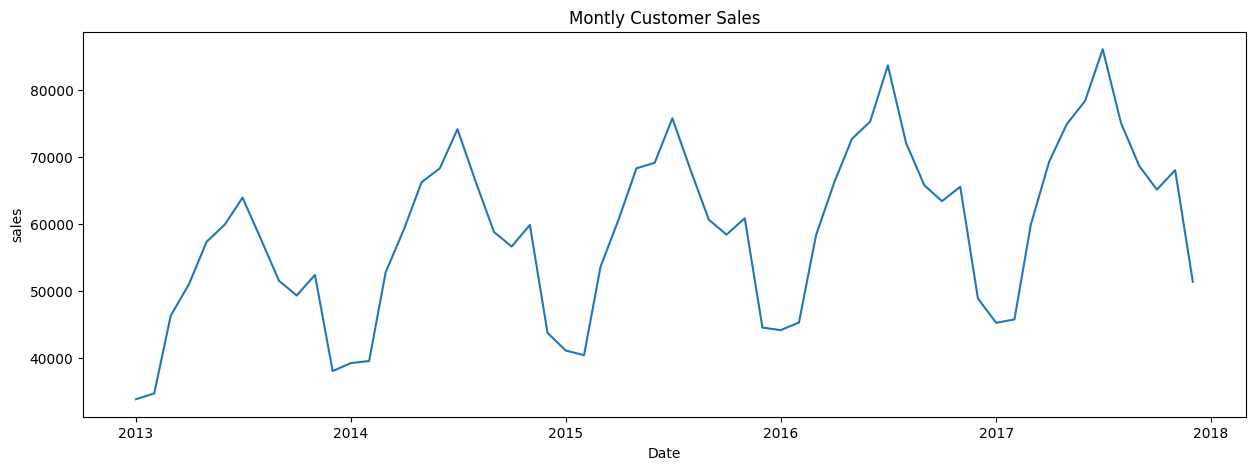

In [92]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [93]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,34765,872.0
2,2013-03-01,46370,11605.0
3,2013-04-01,51070,4700.0
4,2013-05-01,57400,6330.0
5,2013-06-01,59976,2576.0
6,2013-07-01,63981,4005.0
7,2013-08-01,57825,-6156.0
8,2013-09-01,51551,-6274.0
9,2013-10-01,49381,-2170.0
10,2013-11-01,52448,3067.0


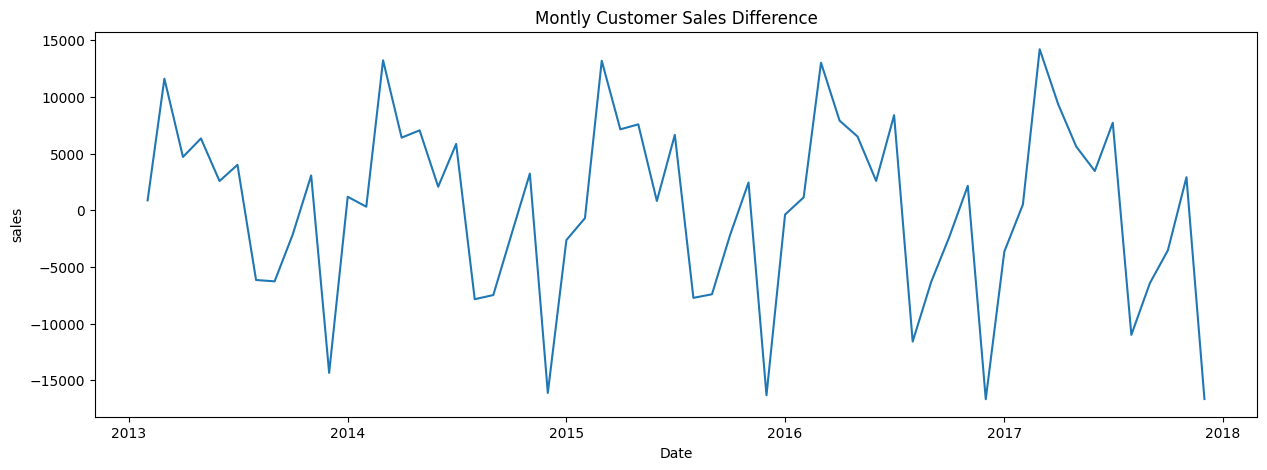

In [94]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [95]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [96]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0,4005.0,2576.0,6330.0,4700.0,11605.0,872.0
1,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0,4005.0,2576.0,6330.0,4700.0,11605.0
2,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0,4005.0,2576.0,6330.0,4700.0
3,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0,4005.0,2576.0,6330.0
4,2073.0,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0,4005.0,2576.0
5,5848.0,2073.0,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0,4005.0
6,-7849.0,5848.0,2073.0,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0,-6156.0
7,-7483.0,-7849.0,5848.0,2073.0,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0,-6274.0
8,-2188.0,-7483.0,-7849.0,5848.0,2073.0,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0,-2170.0
9,3231.0,-2188.0,-7483.0,-7849.0,5848.0,2073.0,7047.0,6404.0,13226.0,310.0,1188.0,-14347.0,3067.0


In [97]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [98]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [99]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [100]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [101]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[48940, 45294, 45802, 60005, 69337, 74954, 78415, 86134, 75137, 68713, 65177, 68089, 51433]


In [102]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [103]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [104]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [105]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  1287.0137628993962
Linaer Regression MAE :  1040.3155733151816
Linaer Regression R2 :  0.9889093579305954


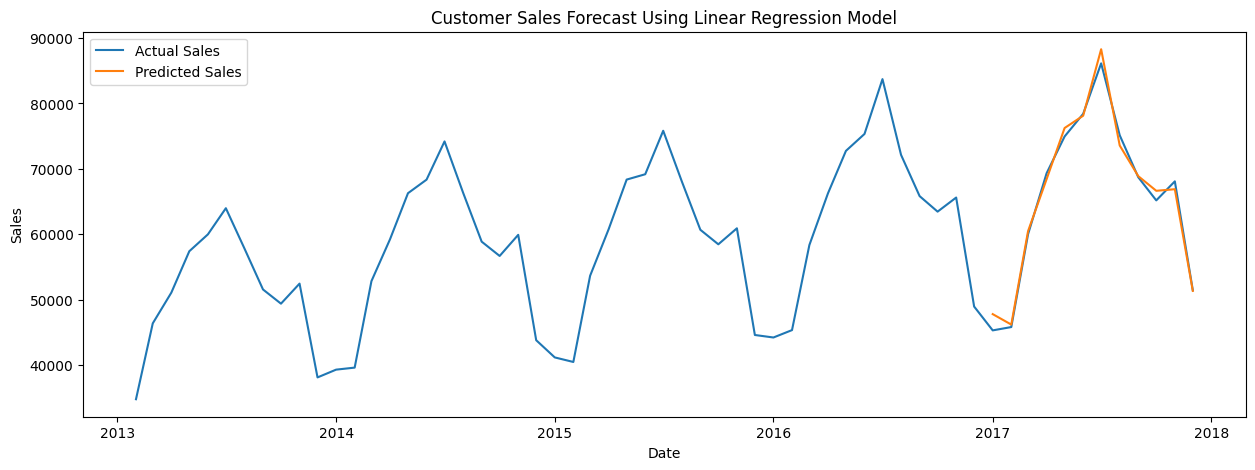

In [106]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()